# Faster R-CNN 으로 Truck과 Bus 탐지하기

## 1. Bus-Truck 데이터셋 살펴보기

In [1]:
import os
import pandas as pd
from utils import CLASS_NAME_TO_ID, visualize

In [2]:
CLASS_NAME_TO_ID

{'Bus': 0, 'Truck': 1}

In [3]:
visualize #coco bbox format 

# X1, Y1, X2, Y2 = XMin, YMin, XMax, YMax -> opencv 기본 좌표 format
# X_cen, Y_cen , W , H -> yolo 시리즈 format
# X_min, y_min, W , H = COCO_DATASET bbox format 

<function utils.visualize(image, bboxes, category_ids)>

In [4]:
data_dir = "../DATASET/Detection/"
data_df = pd.read_csv(os.path.join(data_dir, 'df.csv'))

In [5]:
data_df

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24057,fff2b15ad6007d0e,activemil,Truck,1,0.277344,0.622656,0.226389,0.859722,0,0,...,0,0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
24058,fff376d20410e4c9,xclick,Bus,1,0.295625,0.558750,0.306667,0.397500,1,0,...,1,0,0.424375,0.316250,0.295625,0.558750,0.306667,0.397500,0.382500,0.335833
24059,fff376d20410e4c9,xclick,Bus,1,0.348125,0.701250,0.423333,0.744167,0,0,...,1,0,0.478750,0.493125,0.348125,0.701250,0.423333,0.744167,0.537500,0.523333
24060,fffde5953a818927,xclick,Bus,1,0.277500,0.605625,0.565000,0.795833,0,0,...,0,0,0.488125,0.277500,0.517500,0.605625,0.565000,0.670000,0.795833,0.704167


In [6]:
index = 0
image_files = [fn for fn in os.listdir("../DATASET/Detection/images/") if fn.endswith("jpg")]
image_file = image_files[index]
image_path = os.path.join("../DATASET/Detection/images/", image_file)

In [7]:
image_path

'../DATASET/Detection/images/0000599864fd15b3.jpg'

In [8]:
import cv2
import matplotlib.pyplot as plt

In [9]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [10]:
image

array([[[ 80,  87,  80],
        [ 86,  93,  86],
        [ 93,  95,  94],
        ...,
        [ 93,  91,  94],
        [ 77,  78,  82],
        [121, 125, 128]],

       [[ 79,  83,  82],
        [ 76,  80,  79],
        [ 79,  83,  84],
        ...,
        [ 82,  80,  83],
        [ 92,  93,  95],
        [121, 125, 126]],

       [[ 74,  74,  82],
        [ 68,  71,  78],
        [ 71,  74,  79],
        ...,
        [ 85,  83,  84],
        [ 98, 100,  99],
        [116, 122, 120]],

       ...,

       [[106, 102,  99],
        [108, 104, 101],
        [108, 104, 101],
        ...,
        [165, 157, 144],
        [150, 142, 129],
        [133, 125, 112]],

       [[108, 103,  99],
        [103,  98,  94],
        [111, 108, 103],
        ...,
        [166, 160, 148],
        [160, 154, 142],
        [151, 145, 133]],

       [[117, 112, 108],
        [116, 111, 107],
        [122, 119, 114],
        ...,
        [173, 167, 155],
        [165, 159, 147],
        [162, 156, 144]]

In [11]:
print(image.shape)

(170, 256, 3)


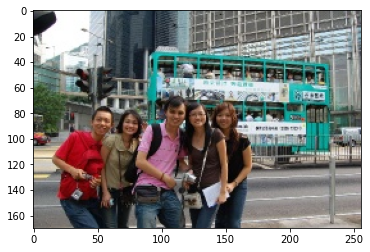

In [12]:
plt.imshow(image)

In [13]:
image_id = image_file.split('.')[0]
meta_data = data_df[data_df['ImageID'] == image_id]

In [14]:
meta_data

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.34375,0.90875,0.156162,0.650047,1,0,...,0,0,0.421875,0.34375,0.795,0.90875,0.156162,0.5127,0.650047,0.457197


In [15]:
cate_names = meta_data["LabelName"].values
bboxes = meta_data[["XMin", "XMax", "YMin", "YMax"]].values

In [16]:
cate_names

array(['Bus'], dtype=object)

In [17]:
bboxes

array([[0.34375 , 0.90875 , 0.156162, 0.650047]])

In [18]:
img_H, img_W, _ = image.shape

class_ids = [CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names]

In [19]:
class_ids

[0]

In [21]:
#계산하기 편하게 XMin , YMin, XMax, YMax로 스위칭
unnorm_bboxes = bboxes.copy()
unnorm_bboxes[:, [1,2]] = unnorm_bboxes[:, [2,1]] #XMin <->YMin
unnorm_bboxes[:, 2:4] -= unnorm_bboxes[:, 0:2]
#XMax , YMax = xmax-xmin, ymax -ymin --> w, h = xmax-xmin, ymax -ymin 이다.
unnorm_bboxes[:, 0:2] += (unnorm_bboxes[:, 2:4] / 2)
# xmin , ymin -> xcenter , ycenter = x_min +w/2, y_min +h/2
# (x_cen, w) / image_w
# (y_cen, h) / image_h
# 원상태로 복원하려면 image w , h로 곱해주면 됨
unnorm_bboxes[:, [0,2]] *= img_W
unnorm_bboxes[:, [1,3]] *= img_H

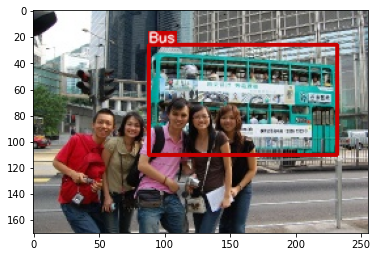

In [22]:
canvas = visualize(image, unnorm_bboxes, class_ids)
plt.figure(figsize=(6,6))
plt.imshow(canvas)
plt.show()

In [23]:
from ipywidgets import interact

In [24]:
@interact(index=(0, len(image_files)-1))
def show_sample(index=0):
    image_file = image_files[index]
    image_path = os.path.join("../DATASET/Detection/images/", image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    image_id = image_file.split('.')[0]
    meta_data = data_df[data_df['ImageID'] == image_id]
    cate_names = meta_data["LabelName"].values
    bboxes = meta_data[["XMin", "XMax", "YMin", "YMax"]].values
    
    img_H, img_W, _ = image.shape

    class_ids = [CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names]
    unnorm_bboxes = bboxes.copy()
    unnorm_bboxes[:, [1,2]] = unnorm_bboxes[:, [2,1]]
    unnorm_bboxes[:, 2:4] -= unnorm_bboxes[:, 0:2]
    unnorm_bboxes[:, 0:2] += (unnorm_bboxes[:, 2:4] / 2)
    unnorm_bboxes[:, [0,2]] *= img_W
    unnorm_bboxes[:, [1,3]] *= img_H
    canvas = visualize(image, unnorm_bboxes, class_ids)
    
    plt.figure(figsize=(6,6))
    plt.imshow(canvas)
    plt.axis('off')
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=15224), Output()), _dom_classes=('widget-int…

## 2. Object detection 데이터셋 구축과 연산을 위한 텐서변환 모듈 작성하기

In [25]:
import torch
import numpy as np

In [26]:
class Detection_dataset(): #phase : train / val 인지 구분 , transformer : tensor형태로 변형
    def __init__(self, data_dir, phase, transformer=None):
        self.data_dir = data_dir
        self.phase = phase
        self.data_df = pd.read_csv(os.path.join(self.data_dir, 'df.csv'))
        self.image_files = [fn for fn in os.listdir(os.path.join(self.data_dir, phase)) if fn.endswith("jpg")]
        self.transformer = transformer
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, index):#input = image, target=label(box, class_id) 호출
        filename, image = self.get_image(index)
        bboxes, class_ids = self.get_label(filename)
        img_H, img_W, _ = image.shape
        if self.transformer:
            image = self.transformer(image)
            # image shape : (H,W,C) -> Tensor shape : (C,H,W)
            _, img_H, img_W = image.shape
            #tensor 형으로 변환 + image size 동일 조정하기 위해
        
        bboxes[:, [0,2]] *= img_W
        #이미지 크기에 맞는 박스 좌표 받기 위해
        bboxes[:, [1,3]] *= img_H
        #bboxes = [[xmin, ymin, xmax, ymax]] -> [0,2]=xmin,xmax / [1,3] = ymin,ymax
        
        target = {}
        target["boxes"] = torch.Tensor(bboxes).float()
        target["labels"] = torch.Tensor(class_ids).long()
            
        return image, target, filename
        #학습에는 image, target 만 씀 / filename은 coco API를 통해 eval하기 위해    
        
    #get_image -> filename(imageid) -> get_label
    def get_image(self, index):
        filename = self.image_files[index]
        image_path = os.path.join(self.data_dir, self.phase, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return filename, image
    
    def get_label(self, filename):
        image_id = filename.split('.')[0]
        meta_data = self.data_df[self.data_df['ImageID'] == image_id]
        cate_names = meta_data["LabelName"].values
        class_ids = np.array([CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names])
        bboxes = meta_data[["XMin", "XMax", "YMin", "YMax"]].values
        bboxes[:, [1,2]] = bboxes[:, [2,1]]
        return bboxes, class_ids
    
    # X1, Y1, X2, Y2 = XMin, YMin, XMax, YMax -> opencv 기본 좌표 format
    # X_cen, Y_cen , W , H -> yolo 시리즈 format
    # X_min, y_min, W , H = COCO_DATASET bbox format 

In [27]:
data_dir = "../DATASET/Detection/"
dataset = Detection_dataset(data_dir=data_dir, phase="train", transformer=None)

In [28]:
dataset[0]

(array([[[ 80,  87,  80],
         [ 86,  93,  86],
         [ 93,  95,  94],
         ...,
         [ 93,  91,  94],
         [ 77,  78,  82],
         [121, 125, 128]],
 
        [[ 79,  83,  82],
         [ 76,  80,  79],
         [ 79,  83,  84],
         ...,
         [ 82,  80,  83],
         [ 92,  93,  95],
         [121, 125, 126]],
 
        [[ 74,  74,  82],
         [ 68,  71,  78],
         [ 71,  74,  79],
         ...,
         [ 85,  83,  84],
         [ 98, 100,  99],
         [116, 122, 120]],
 
        ...,
 
        [[106, 102,  99],
         [108, 104, 101],
         [108, 104, 101],
         ...,
         [165, 157, 144],
         [150, 142, 129],
         [133, 125, 112]],
 
        [[108, 103,  99],
         [103,  98,  94],
         [111, 108, 103],
         ...,
         [166, 160, 148],
         [160, 154, 142],
         [151, 145, 133]],
 
        [[117, 112, 108],
         [116, 111, 107],
         [122, 119, 114],
         ...,
         [173, 167, 155],
  

In [29]:
len(dataset)

13703

In [37]:
image, target, filename = dataset[index]

In [38]:
image.shape

(170, 256, 3)

In [39]:
target

{'boxes': tensor([[ 70.8268,  24.0727, 178.5600,  74.3483],
         [179.8400,  34.7244, 255.7868,  69.6616]]),
 'labels': tensor([1, 1])}

In [40]:
filename

'00006bdb1eb5cd74.jpg'

In [41]:
dataset.data_df.iloc[0]

ImageID        0000599864fd15b3
Source                   xclick
LabelName                   Bus
Confidence                    1
XMin                    0.34375
XMax                    0.90875
YMin                   0.156162
YMax                   0.650047
IsOccluded                    1
IsTruncated                   0
IsGroupOf                     0
IsDepiction                   0
IsInside                      0
XClick1X               0.421875
XClick2X                0.34375
XClick3X                  0.795
XClick4X                0.90875
XClick1Y               0.156162
XClick2Y                 0.5127
XClick3Y               0.650047
XClick4Y               0.457197
Name: 0, dtype: object

In [42]:
print(0.34375*256)
print(0.156162*170)
print(00.90875*256)
print(0.650047*170)

88.0
26.547539999999998
232.64
110.50799


In [43]:
index = 1
image, target, filename = dataset[index]

In [44]:
target

{'boxes': tensor([[ 70.8268,  24.0727, 178.5600,  74.3483],
         [179.8400,  34.7244, 255.7868,  69.6616]]),
 'labels': tensor([1, 1])}

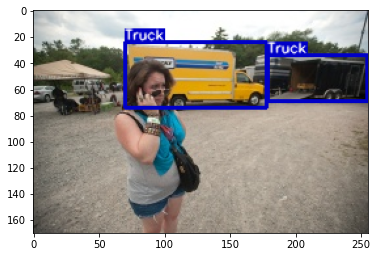

In [45]:
boxes = target['boxes'].numpy()
class_ids = target['labels'].numpy()

n_obj = boxes.shape[0]
bboxes = np.zeros(shape=(n_obj, 4), dtype=np.float32)
bboxes[:, 0:2] = (boxes[:, 0:2] + boxes[:, 2:4]) / 2
bboxes[:, 2:4] = boxes[:, 2:4] - boxes[:, 0:2]

canvas = visualize(image, bboxes, class_ids)

plt.figure(figsize=(6,6))
plt.imshow(canvas)
plt.show()

In [46]:
@interact(index=(0, len(dataset)-1))
def show_sample(index=0):
    image, target, filename = dataset[index]
    boxes = target['boxes'].numpy()
    class_ids = target['labels'].numpy()

    n_obj = boxes.shape[0]
    bboxes = np.zeros(shape=(n_obj, 4), dtype=np.float32)
    bboxes[:, 0:2] = (boxes[:, 0:2] + boxes[:, 2:4]) / 2
    bboxes[:, 2:4] = boxes[:, 2:4] - boxes[:, 0:2]

    canvas = visualize(image, bboxes, class_ids)

    plt.figure(figsize=(6,6))
    plt.imshow(canvas)
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=13702), Output()), _dom_classes=('widget-int…

In [47]:
bboxes

array([[124.693375,  49.210495, 107.733246,  50.275635],
       [217.81339 ,  52.192978,  75.94676 ,  34.937214]], dtype=float32)

In [48]:
from torchvision import transforms

In [49]:
IMAGE_SIZE = 448

transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [50]:
transformer

Compose(
    ToTensor()
    Resize(size=(448, 448), interpolation=bilinear, max_size=None, antialias=warn)
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [51]:
data_dir = "../DATASET/Detection/"
transformed_dataset = Detection_dataset(data_dir=data_dir, phase="train", transformer=transformer)

In [52]:
from torchvision.utils import make_grid
#transformer 에 들어온 dataset이 잘 변환이 되었는지 확인
#make_grid로 normalize 된 것을 unnormalize

In [53]:
index = 5
image, target, filename = transformed_dataset[index]

C:\Users\admin\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [54]:
image

tensor([[[ 2.1119,  2.1303,  2.1596,  ...,  1.7095,  1.6410,  1.5982],
         [ 2.1119,  2.1303,  2.1596,  ...,  1.7095,  1.6410,  1.5982],
         [ 2.1327,  2.1473,  2.1708,  ...,  1.4807,  1.4538,  1.4370],
         ...,
         [ 2.2385,  2.2154,  2.1783,  ...,  2.2482,  2.2422,  2.2385],
         [ 2.2489,  2.2183,  2.1694,  ...,  2.2489,  2.2489,  2.2489],
         [ 2.2489,  2.2183,  2.1694,  ...,  2.2489,  2.2489,  2.2489]],

        [[ 2.3060,  2.3248,  2.3548,  ..., -0.9115, -1.0216, -1.0903],
         [ 2.3060,  2.3248,  2.3548,  ..., -0.9115, -1.0216, -1.0903],
         [ 2.3273,  2.3422,  2.3662,  ..., -1.0007, -1.0591, -1.0957],
         ...,
         [ 2.3829,  2.3612,  2.3263,  ...,  2.4099,  2.4008,  2.3951],
         [ 2.3936,  2.3623,  2.3123,  ...,  2.4111,  2.4111,  2.4111],
         [ 2.3936,  2.3623,  2.3123,  ...,  2.4111,  2.4111,  2.4111]],

        [[ 2.5877,  2.6064,  2.6363,  ..., -0.3030, -0.4226, -0.4973],
         [ 2.5877,  2.6064,  2.6363,  ..., -0

In [55]:
image.shape #(C,H,W)

torch.Size([3, 448, 448])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


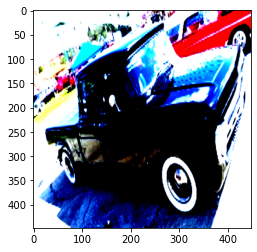

In [56]:
plt.imshow(image.permute(1,2,0).numpy()) #normalize된 image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


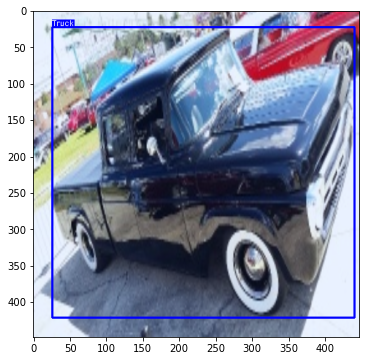

In [57]:
#unnormalize 적용
np_image = make_grid(image, normalize=True).cpu().permute(1,2,0).numpy()
boxes = target['boxes'].numpy()
class_ids = target['labels'].numpy()

n_obj = boxes.shape[0]
bboxes = np.zeros(shape=(n_obj, 4), dtype=np.float32)
bboxes[:, 0:2] = (boxes[:, 0:2] + boxes[:, 2:4]) / 2
bboxes[:, 2:4] = boxes[:, 2:4] - boxes[:, 0:2]

canvas = visualize(np_image, bboxes, class_ids)

plt.figure(figsize=(6,6))
plt.imshow(canvas)
plt.show()

In [58]:
canvas.shape

(448, 448, 3)

In [59]:
from torch.utils.data import DataLoader

In [60]:
# image 값과 target 값을 묶어서 mini_batch형태로 iterate하게 받기 위한 collate_fn함수
def collate_fn(batch):
    image_list = []
    target_list = []
    filename_list = []
    
    for a,b,c in batch:
        image_list.append(a)
        target_list.append(b)
        filename_list.append(c)

    return image_list, target_list, filename_list

In [61]:
data_dir = "../DATASET/Detection/"
BATCH_SIZE = 6

trainset = Detection_dataset(data_dir=data_dir, phase="train", transformer=transformer)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [62]:
for index, batch in enumerate(trainloader):
    images = batch[0]
    targets = batch[1]
    filenames = batch[2]
    
    if index == 0: #하나 먼저 확인
        break

C:\Users\admin\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acr

In [63]:
images

[tensor([[[-0.0629, -0.0872, -0.1262,  ...,  2.1066,  2.0676,  2.0434],
          [-0.0874, -0.0900, -0.0942,  ...,  2.1142,  2.0856,  2.0679],
          [-0.1265, -0.0945, -0.0430,  ...,  2.1262,  2.1144,  2.1070],
          ...,
          [-1.0439, -1.0911, -1.1670,  ..., -1.4809, -1.4739, -1.4696],
          [-1.2201, -1.2569, -1.3160,  ..., -1.4643, -1.4797, -1.4892],
          [-1.3302, -1.3605, -1.4092,  ..., -1.4540, -1.4832, -1.5014]],
 
         [[ 0.1176,  0.0991,  0.0692,  ...,  2.1956,  2.1557,  2.1310],
          [ 0.0926,  0.0962,  0.1019,  ...,  2.2033,  2.1741,  2.1560],
          [ 0.0526,  0.0916,  0.1542,  ...,  2.2156,  2.2035,  2.1960],
          ...,
          [-0.8690, -0.9172, -0.9948,  ..., -1.3145, -1.3073, -1.3029],
          [-1.0591, -1.0967, -1.1572,  ..., -1.2975, -1.3132, -1.3229],
          [-1.1779, -1.2088, -1.2587,  ..., -1.2870, -1.3169, -1.3354]],
 
         [[ 0.4614,  0.4552,  0.4453,  ...,  2.0595,  2.0198,  1.9951],
          [ 0.4365,  0.4523,

In [64]:
len(images)

6

In [65]:
images[0].shape

torch.Size([3, 448, 448])

In [66]:
targets

[{'boxes': tensor([[143.4276, 147.5600, 433.9386, 431.4800]]),
  'labels': tensor([0])},
 {'boxes': tensor([[ 77.0000,  89.2237, 416.0800, 335.4351]]),
  'labels': tensor([1])},
 {'boxes': tensor([[ 99.9600, 137.3868, 290.9200, 262.4532]]),
  'labels': tensor([0])},
 {'boxes': tensor([[ 59.0800, 110.8800, 283.9200, 367.7332]]),
  'labels': tensor([1])},
 {'boxes': tensor([[140.2800, 163.0442, 246.9600, 266.6196]]),
  'labels': tensor([0])},
 {'boxes': tensor([[256.2000,  79.6750, 413.0000, 381.9836]]),
  'labels': tensor([0])}]

In [67]:
filenames

['c66ac76e893fb4c2.jpg',
 '03bac956061bb87e.jpg',
 '3768b09730363766.jpg',
 '4373019ece1a34ad.jpg',
 '2662d5d51bc8984d.jpg',
 '3bbf6883b5f7ca1e.jpg']

In [68]:
def build_dataloader(data_dir, batch_size=4, image_size=448):
    transformer = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(size=(image_size, image_size)),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    dataloaders = {}
    train_dataset = Detection_dataset(data_dir=data_dir, phase="train", transformer=transformer)
    dataloaders["train"] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    val_dataset = Detection_dataset(data_dir=data_dir, phase="val", transformer=transformer)
    dataloaders["val"] = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
    return dataloaders

In [69]:
data_dir = "../DATASET/Detection/"
dloaders = build_dataloader(data_dir, batch_size=4, image_size=448)

for phase in ["train", "val"]:
    for index, batch in enumerate(dloaders[phase]):
        images = batch[0]
        targets = batch[1]
        filenames = batch[2]
        print(targets)
        if index == 0:
            break

[{'boxes': tensor([[  0.0000, 249.3868,   6.4400, 331.8932],
        [  8.6800, 259.0932,  52.0800, 325.5468],
        [ 41.7200, 256.8532, 132.4400, 368.8532],
        [180.0400, 232.2132, 447.7200, 447.6268]]), 'labels': tensor([0, 0, 0, 0])}, {'boxes': tensor([[208.8800,   8.4054, 401.8000, 325.2834]]), 'labels': tensor([0])}, {'boxes': tensor([[ 15.1200, 155.3068, 108.3600, 204.5868]]), 'labels': tensor([1])}, {'boxes': tensor([[  0.0000, 179.5732,  73.9200, 269.9200],
        [ 72.8000, 133.2800, 413.5600, 344.2132]]), 'labels': tensor([0, 0])}]
[{'boxes': tensor([[ 80.9200, 186.5965, 303.5200, 393.7862]]), 'labels': tensor([1])}]


C:\Users\admin\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acr

## 3. Faster R-CNN 아키텍처 불러오기

In [70]:
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#FastRCNNPredictor head를 통해서 model에서 제공하는 head와 변경

In [71]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

C:\Users\admin\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [72]:
model # out_features=91 -> 2로 바꿔야함

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [73]:
def build_model(num_classes):
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [74]:
NUM_CLASSES = 2
model = build_model(num_classes=NUM_CLASSES)

In [75]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## 4. Detector 학습을 위한 코드 작성하기

In [76]:
phase = 'train'
model.train()

for index, batch in enumerate(dloaders[phase]):
    images = batch[0]
    targets = batch[1]
    filenames = batch[2]
        
    images = list(image for image in images)
    targets = [{k: v for k, v in t.items()} for t in targets]
    
    loss = model(images, targets)
    if index == 0:
        break

C:\Users\admin\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent acr

In [77]:
loss

{'loss_classifier': tensor(1.1786, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0687, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.2325, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0236, grad_fn=<DivBackward0>)}

In [40]:
# loss 를 매 epoch당 담기 위한 defaultdict 선언
from collections import defaultdict

def train_one_epoch(dataloaders, model, optimizer, device):
    train_loss = defaultdict(float)
    val_loss = defaultdict(float)
    
    model.train()
    
    for phase in ["train", "val"]:
        for index, batch in enumerate(dataloaders[phase]):
            images = batch[0]
            targets = batch[1]
            filenames = batch[2]
    
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            with torch.set_grad_enabled(phase == "train"):
                loss = model(images, targets)
            total_loss = sum(each_loss for each_loss in loss.values())
            
            if phase == "train":
                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()
                
                #loss가 잘 감소하는지 확인
                if (index > 0) and (index % VERBOSE_FREQ) == 0:
                    text = f"{index}/{len(dataloaders[phase])} - "
                    for k, v in loss.items():
                        text += f"{k}: {v.item():.4f}  "
                    print(text)

                for k, v in loss.items():
                    train_loss[k] += v.item()
                train_loss["total_loss"] += total_loss.item()
                
            else:
                for k, v in loss.items():
                    val_loss[k] += v.item()
                val_loss["total_loss"] += total_loss.item()
                
    for k in train_loss.keys():
        train_loss[k] /= len(dataloaders["train"])
        val_loss[k] /= len(dataloaders["val"])
    return train_loss, val_loss

In [41]:
from utils import save_model

In [42]:
data_dir = "../DATASET/Detection/"
is_cuda = True

NUM_CLASSES = 2
IMAGE_SIZE = 448
BATCH_SIZE = 6
VERBOSE_FREQ = 200
DEVICE = torch.device('cuda' if torch.cuda.is_available and is_cuda else 'cpu')

dataloaders = build_dataloader(data_dir=data_dir, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)
model = build_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [43]:
num_epochs = 30

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss, val_loss = train_one_epoch(dataloaders, model, optimizer, DEVICE)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"epoch:{epoch+1}/{num_epochs} - Train Loss: {train_loss['total_loss']:.4f}, Val Loss: {val_loss['total_loss']:.4f}")
    
    if (epoch+1) % 10 == 0:
        save_model(model.state_dict(), f'model_{epoch+1}.pth')

200/2284 - loss_classifier: 0.0978  loss_box_reg: 0.1096  loss_objectness: 0.0170  loss_rpn_box_reg: 0.0073  
400/2284 - loss_classifier: 0.0332  loss_box_reg: 0.0421  loss_objectness: 0.0092  loss_rpn_box_reg: 0.0061  
600/2284 - loss_classifier: 0.0345  loss_box_reg: 0.0471  loss_objectness: 0.0012  loss_rpn_box_reg: 0.0050  
800/2284 - loss_classifier: 0.0371  loss_box_reg: 0.0576  loss_objectness: 0.0135  loss_rpn_box_reg: 0.0062  
1000/2284 - loss_classifier: 0.0125  loss_box_reg: 0.0000  loss_objectness: 0.0108  loss_rpn_box_reg: 0.0074  
1200/2284 - loss_classifier: 0.0093  loss_box_reg: 0.0084  loss_objectness: 0.0834  loss_rpn_box_reg: 0.0578  
1400/2284 - loss_classifier: 0.0266  loss_box_reg: 0.0099  loss_objectness: 0.0098  loss_rpn_box_reg: 0.0065  
1600/2284 - loss_classifier: 0.1120  loss_box_reg: 0.0939  loss_objectness: 0.0265  loss_rpn_box_reg: 0.0182  
1800/2284 - loss_classifier: 0.0301  loss_box_reg: 0.0263  loss_objectness: 0.0087  loss_rpn_box_reg: 0.0032  
2000/

1400/2284 - loss_classifier: 0.0222  loss_box_reg: 0.0417  loss_objectness: 0.0029  loss_rpn_box_reg: 0.0021  
1600/2284 - loss_classifier: 0.0063  loss_box_reg: 0.0086  loss_objectness: 0.0030  loss_rpn_box_reg: 0.0023  
1800/2284 - loss_classifier: 0.0110  loss_box_reg: 0.0147  loss_objectness: 0.0024  loss_rpn_box_reg: 0.0040  
2000/2284 - loss_classifier: 0.0160  loss_box_reg: 0.0216  loss_objectness: 0.0048  loss_rpn_box_reg: 0.0057  
2200/2284 - loss_classifier: 0.0290  loss_box_reg: 0.0526  loss_objectness: 0.0097  loss_rpn_box_reg: 0.0079  
epoch:7/30 - Train Loss: 0.0642, Val Loss: 0.1142
200/2284 - loss_classifier: 0.0302  loss_box_reg: 0.0618  loss_objectness: 0.0016  loss_rpn_box_reg: 0.0033  
400/2284 - loss_classifier: 0.0139  loss_box_reg: 0.0284  loss_objectness: 0.0049  loss_rpn_box_reg: 0.0032  
600/2284 - loss_classifier: 0.0241  loss_box_reg: 0.0474  loss_objectness: 0.0028  loss_rpn_box_reg: 0.0035  
800/2284 - loss_classifier: 0.0276  loss_box_reg: 0.0559  loss_ob

200/2284 - loss_classifier: 0.0103  loss_box_reg: 0.0177  loss_objectness: 0.0006  loss_rpn_box_reg: 0.0013  
400/2284 - loss_classifier: 0.0188  loss_box_reg: 0.0301  loss_objectness: 0.0026  loss_rpn_box_reg: 0.0028  
600/2284 - loss_classifier: 0.0082  loss_box_reg: 0.0148  loss_objectness: 0.0002  loss_rpn_box_reg: 0.0024  
800/2284 - loss_classifier: 0.0049  loss_box_reg: 0.0068  loss_objectness: 0.0059  loss_rpn_box_reg: 0.0067  
1000/2284 - loss_classifier: 0.0056  loss_box_reg: 0.0119  loss_objectness: 0.0060  loss_rpn_box_reg: 0.0138  
1200/2284 - loss_classifier: 0.0035  loss_box_reg: 0.0053  loss_objectness: 0.0029  loss_rpn_box_reg: 0.0013  
1400/2284 - loss_classifier: 0.0117  loss_box_reg: 0.0191  loss_objectness: 0.0029  loss_rpn_box_reg: 0.0037  
1600/2284 - loss_classifier: 0.0210  loss_box_reg: 0.0474  loss_objectness: 0.0006  loss_rpn_box_reg: 0.0019  
1800/2284 - loss_classifier: 0.0170  loss_box_reg: 0.0347  loss_objectness: 0.0041  loss_rpn_box_reg: 0.0030  
2000/

1400/2284 - loss_classifier: 0.0159  loss_box_reg: 0.0206  loss_objectness: 0.0007  loss_rpn_box_reg: 0.0081  
1600/2284 - loss_classifier: 0.0067  loss_box_reg: 0.0129  loss_objectness: 0.0016  loss_rpn_box_reg: 0.0019  
1800/2284 - loss_classifier: 0.0093  loss_box_reg: 0.0141  loss_objectness: 0.0011  loss_rpn_box_reg: 0.0020  
2000/2284 - loss_classifier: 0.0024  loss_box_reg: 0.0043  loss_objectness: 0.0014  loss_rpn_box_reg: 0.0046  
2200/2284 - loss_classifier: 0.0174  loss_box_reg: 0.0301  loss_objectness: 0.0012  loss_rpn_box_reg: 0.0049  
epoch:20/30 - Train Loss: 0.0306, Val Loss: 0.1718
200/2284 - loss_classifier: 0.0031  loss_box_reg: 0.0052  loss_objectness: 0.0005  loss_rpn_box_reg: 0.0049  
400/2284 - loss_classifier: 0.0048  loss_box_reg: 0.0130  loss_objectness: 0.0015  loss_rpn_box_reg: 0.0023  
600/2284 - loss_classifier: 0.0083  loss_box_reg: 0.0134  loss_objectness: 0.0006  loss_rpn_box_reg: 0.0033  
800/2284 - loss_classifier: 0.0022  loss_box_reg: 0.0056  loss_o

200/2284 - loss_classifier: 0.0083  loss_box_reg: 0.0113  loss_objectness: 0.0001  loss_rpn_box_reg: 0.0011  
400/2284 - loss_classifier: 0.0033  loss_box_reg: 0.0098  loss_objectness: 0.0001  loss_rpn_box_reg: 0.0024  
600/2284 - loss_classifier: 0.0052  loss_box_reg: 0.0084  loss_objectness: 0.0003  loss_rpn_box_reg: 0.0034  
800/2284 - loss_classifier: 0.0061  loss_box_reg: 0.0094  loss_objectness: 0.0007  loss_rpn_box_reg: 0.0051  
1000/2284 - loss_classifier: 0.0035  loss_box_reg: 0.0060  loss_objectness: 0.0001  loss_rpn_box_reg: 0.0015  
1200/2284 - loss_classifier: 0.0077  loss_box_reg: 0.0114  loss_objectness: 0.0003  loss_rpn_box_reg: 0.0026  
1400/2284 - loss_classifier: 0.0020  loss_box_reg: 0.0037  loss_objectness: 0.0016  loss_rpn_box_reg: 0.0021  
1600/2284 - loss_classifier: 0.0034  loss_box_reg: 0.0053  loss_objectness: 0.0001  loss_rpn_box_reg: 0.0011  
1800/2284 - loss_classifier: 0.0079  loss_box_reg: 0.0151  loss_objectness: 0.0012  loss_rpn_box_reg: 0.0013  
2000/

In [47]:
tr_loss_classifier = [] 
tr_loss_box_reg = []
tr_loss_objectness = []
tr_loss_rpn_box_reg = []
tr_loss_total = []

for tr_loss in train_losses:
    tr_loss_classifier.append(tr_loss['loss_classifier'])
    tr_loss_box_reg.append(tr_loss['loss_box_reg'])
    tr_loss_objectness.append(tr_loss['loss_objectness'])
    tr_loss_rpn_box_reg.append(tr_loss['loss_rpn_box_reg'])
    tr_loss_total.append(tr_loss['total_loss'])

val_loss_classifier = [] 
val_loss_box_reg = []
val_loss_objectness = []
val_loss_rpn_box_reg = []
val_loss_total = []

for vl_loss in val_losses:
    val_loss_classifier.append(vl_loss['loss_classifier'])
    val_loss_box_reg.append(vl_loss['loss_box_reg'])
    val_loss_objectness.append(vl_loss['loss_objectness'])
    val_loss_rpn_box_reg.append(vl_loss['loss_rpn_box_reg'])
    val_loss_total.append(vl_loss['total_loss'])

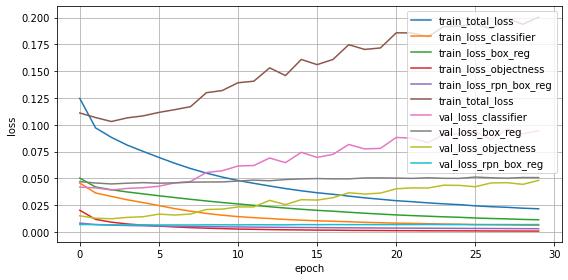

In [48]:
plt.figure(figsize=(8, 4))
plt.plot(tr_loss_total, label="train_total_loss")
plt.plot(tr_loss_classifier, label="train_loss_classifier")
plt.plot(tr_loss_box_reg,  label="train_loss_box_reg")
plt.plot(tr_loss_objectness, label="train_loss_objectness")
plt.plot(tr_loss_rpn_box_reg,  label="train_loss_rpn_box_reg")

plt.plot(val_loss_total, label="train_total_loss")
plt.plot(val_loss_classifier, label="val_loss_classifier")
plt.plot(val_loss_box_reg,  label="val_loss_box_reg")
plt.plot(val_loss_objectness, label="val_loss_objectness")
plt.plot(val_loss_rpn_box_reg,  label="val_loss_rpn_box_reg")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend(loc='upper right')
plt.tight_layout()

## 5. Confidence threshold 와 Non-maximum suppression(NMS) 소개와 적용해보기

In [42]:
import torch

In [43]:
def load_model(ckpt_path, num_classes, device):
    checkpoint = torch.load(ckpt_path, map_location=device)
    model = build_model(num_classes=num_classes)
    model.load_state_dict(checkpoint)
    model = model.to(device)
    model.eval()
    return model

In [44]:
is_cuda = True

NUM_CLASSES = 2
DEVICE = torch.device('cuda' if is_cuda and torch.cuda.is_available() else 'cpu')

data_dir = "../DATASET/Detection/"
dataloaders = build_dataloader(data_dir, batch_size=1)
num_classes = len(CLASS_NAME_TO_ID)

model = load_model(ckpt_path='./trained_model/model_30.pth', num_classes=NUM_CLASSES, device=DEVICE)

In [45]:
from torchvision.ops import nms

def postprocess(prediction, conf_thres=0.2, IoU_threshold=0.1):
    pred_box = prediction["boxes"].cpu().detach().numpy()
    pred_label = prediction["labels"].cpu().detach().numpy()
    pred_conf = prediction['scores'].cpu().detach().numpy()
    
    conf_thres = 0.2
    valid_index = pred_conf > conf_thres
    pred_box = pred_box[valid_index]
    pred_label = pred_label[valid_index]
    pred_conf = pred_conf[valid_index]
    
    valid_index = nms(torch.tensor(pred_box.astype(np.float32)), torch.tensor(pred_conf), IoU_threshold)
    pred_box = pred_box[valid_index.numpy()]
    pred_conf = pred_conf[valid_index.numpy()]
    pred_label = pred_label[valid_index.numpy()]
    return np.concatenate((pred_box, pred_conf[:, np.newaxis], pred_label[:, np.newaxis]), axis=1)

In [46]:
from torchvision.utils import make_grid

In [53]:
pred_images = []
pred_labels =[]

for index, (images, _, filenames) in enumerate(dataloaders["val"]):
    images = list(image.to(DEVICE) for image in images)
    filename = filenames[0]
    
    #(C,H,W) -> (H,W,C)
    #보기 쉽게 unnormalize
    image = make_grid(images[0].cpu().detach(), normalize=True).permute(1,2,0).numpy()
    image = (image * 255).astype(np.uint8)
    
    with torch.no_grad():
        prediction = model(images)
        
    prediction = postprocess(prediction[0])
    prediction[:, 2].clip(min=0, max=image.shape[1])
    prediction[:, 3].clip(min=0, max=image.shape[0])
    #이미지 크기보다 박스 크기 크지않게 cliping
    
    # display 하기 위해선 yolo format해야함
    xc = (prediction[:, 0] + prediction[:, 2])/2 #xmin + xmax /2 = x_cen
    yc = (prediction[:, 1] + prediction[:, 3])/2 #ymin + ymax /2 = y_cen
    w = prediction[:, 2] - prediction[:, 0]
    h = prediction[:, 3] - prediction[:, 1]
    cls_id = prediction[:, 5]
    prediction_yolo = np.stack([xc,yc, w,h, cls_id], axis=1)
    
    pred_images.append(image)
    pred_labels.append(prediction_yolo)
    
    if index == 1:
        break

In [54]:
from ipywidgets import interact

@interact(index=(0,len(pred_images)-1))
def show_result(index=0):
    result = visualize(pred_images[index], pred_labels[index][:, 0:4], pred_labels[index][:, 4])
                                                            #box 좌표                 #label좌표
    plt.figure(figsize=(6,6))
    plt.imshow(result)
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=1), Output()), _dom_classes=('widget-interac…

## 6. 탐지성능검증을 위한 지표 소개 및 적용해보기

In [47]:
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [48]:
annFile = "../DATASET/Detection/val.json"
with open(annFile, mode='r') as f:
    json_data = json.load(f)
imageToid = json_data["imageToid"]
cocoGt=COCO(annFile)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [49]:
def XminYminXmaxYmax_to_XminYminWH(box):
    Xmin = box[:, 0]
    Ymin = box[:, 1]
    W = box[:, 2] - box[:, 0]
    H = box[:, 3] - box[:, 1]
    return np.stack((Xmin, Ymin, W, H), axis=1)

In [51]:
COCO_anno = []

for index, (images, _, filenames) in enumerate(dataloaders["val"]):
    images = list(image.to(DEVICE) for image in images)
    filename = filenames[0]
    #dataloaders["val"].batch_size 가 1이므로 filenames[0] -> 리스트에 첫번째만 가져와도
    # 결국엔 item을 모두 갖고 오게 되는것이 된다.
    
    image = make_grid(images[0].cpu().detach(), normalize=True).permute(1,2,0).numpy()
    image = (image * 255).astype(np.uint8)
    
    with torch.no_grad():
        prediction = model(images)
        
    prediction = postprocess(prediction[0])
    #prediction[:, 0].clip(min=0)
    #prediction[:, 1].clip(min=0)
    #prediction[:, 2].clip(max=IMAGE_SIZE)
    #prediction[:, 3].clip(max=IMAGE_SIZE)은 밑 코드와 같다
    prediction[:, 2].clip(min=0, max=image.shape[1])
    prediction[:, 3].clip(min=0, max=image.shape[0])
    
    # XminYminXmaxYmax -> COCO format -> XminYminWH
    box_xywh = XminYminXmaxYmax_to_XminYminWH(prediction[:, 0:4])
    score = prediction[:, 4][:, np.newaxis]
    cls_id = prediction[:, 5][:, np.newaxis]
    img_id = np.array([imageToid[filename], ] * len(cls_id))[:, np.newaxis]

    COCO_anno.append(np.concatenate((img_id, box_xywh, score, cls_id), axis=1))

    if index % 50 == 0:
        print(f"{index}/{len(dataloaders['val'])} Done.")

COCO_anno = np.concatenate(COCO_anno, axis=0)

0/1522 Done.
50/1522 Done.
100/1522 Done.
150/1522 Done.
200/1522 Done.
250/1522 Done.
300/1522 Done.
350/1522 Done.
400/1522 Done.
450/1522 Done.
500/1522 Done.
550/1522 Done.
600/1522 Done.
650/1522 Done.
700/1522 Done.
750/1522 Done.
800/1522 Done.
850/1522 Done.
900/1522 Done.
950/1522 Done.
1000/1522 Done.
1050/1522 Done.
1100/1522 Done.
1150/1522 Done.
1200/1522 Done.
1250/1522 Done.
1300/1522 Done.
1350/1522 Done.
1400/1522 Done.
1450/1522 Done.
1500/1522 Done.


In [52]:
cocoDt = cocoGt.loadRes(COCO_anno)

Loading and preparing results...
Converting ndarray to lists...
(1453, 7)
0/1453
DONE (t=0.01s)
creating index...
index created!


In [55]:
annType = "bbox"
cocoEval = COCOeval(cocoGt,cocoDt,annType)
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()
eval_stats = cocoEval.stats
# Faster R-CNN(30 epoch) mAP@.50 = 0.313 

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.47s).
Accumulating evaluation results...
DONE (t=0.11s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.204
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.313
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.234
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.094
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.274
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.215
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.252
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.252
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.024
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100

In [115]:
annType = "bbox"
cocoEval = COCOeval(cocoGt,cocoDt,annType)
cocoEval.params.areaRng = [[0, 1e+8], [0, 20**2], [20**2, 100**2], [100**2, 1e+8]]
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()
eval_stats = cocoEval.stats

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.58s).
Accumulating evaluation results...
DONE (t=0.10s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.206
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.316
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.237
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.089
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.277
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.215
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.255
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.255
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100

In [116]:
# del images, prediction
torch.cuda.empty_cache()

## 7. Faster RCNN 모델 테스트해보기

In [52]:
from time import time

In [62]:
video_path = "../DATASET/sample_video.mp4"

In [63]:
transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

@torch.no_grad()
def model_predict(image, model):
    tensor_image = transformer(image)
    tensor_image = tensor_image.to(DEVICE)
    
    prediction = model([tensor_image])
    return prediction

In [64]:
vid = cv2.VideoCapture(video_path)

while (vid.isOpened()):
    ret, frame = vid.read()
    
    if ret:
        since = time()
        ori_h, ori_w = frame.shape[:2]
        image = cv2.resize(frame, dsize=(IMAGE_SIZE, IMAGE_SIZE))
        prediction = model_predict(image, model)
        prediction = postprocess(prediction[0])
        prediction[:, [0,2]] *= (ori_w/IMAGE_SIZE)
        prediction[:, [1,3]] *= (ori_h/IMAGE_SIZE)
        prediction[:, 2].clip(min=0, max=ori_w)
        prediction[:, 3].clip(min=0, max=ori_h)
    
        xc = (prediction[:, 0] + prediction[:, 2])/2
        yc = (prediction[:, 1] + prediction[:, 3])/2
        w = prediction[:, 2] - prediction[:, 0]
        h = prediction[:, 3] - prediction[:, 1]
        cls_id = prediction[:, 5]
        prediction_yolo = np.stack([xc,yc, w,h, cls_id], axis=1)
        text= f"{(time() - since)*1000:.0f}ms/image"
        
        canvas = visualize(frame, prediction_yolo[:, 0:4], prediction_yolo[:, 4])
        cv2.putText(canvas, text, (20, 40), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)
        cv2.imshow('camera', canvas)
        
        key = cv2.waitKey(1)
        if key == 27:
            break
        if key == ord('s'):
            cv2.waitKey()
    
vid.release()
cv2.destroyAllWindows()